# Ultimate Technologies Take-Home Challenge

## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [126]:
#Import packages
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [127]:
#Load data
logins = pd.read_json('data/logins.json')

In [128]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [129]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [130]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [131]:
#Aggregate login counts on 15 minute time intervals
logins['count'] = 1
logins_agg = logins.set_index('login_time').resample('15T').sum()
logins_agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [425]:
#There do not seem to be any null values included
logins_agg.isnull().values.any()

False

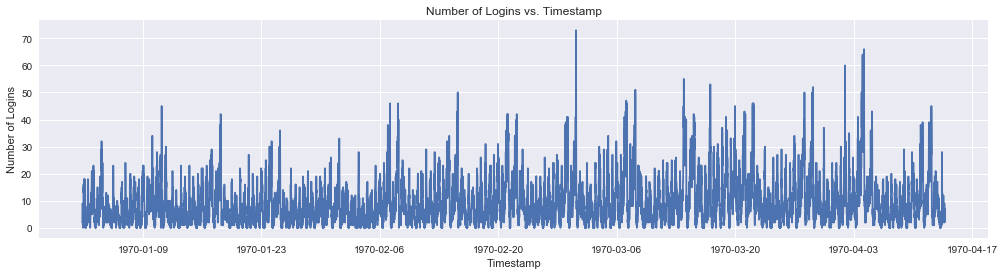

In [133]:
sns.set()
plt.figure(figsize=(17,4))
plt.plot(logins_agg)
plt.title('Number of Logins vs. Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Number of Logins')
plt.show()

Clearly, the plot is pretty tough to gain any insight from as is. I will zoom in and look at only the first week to gain some insights.

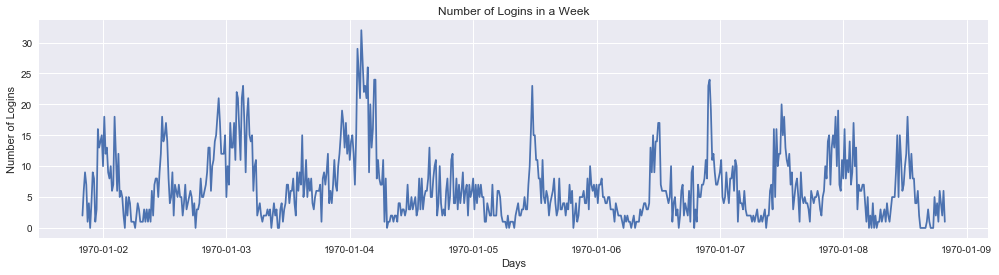

In [134]:
plt.figure(figsize=(17,4))
plt.plot(logins_agg[0:672])
plt.title('Number of Logins in a Week')
plt.xlabel('Days')
plt.ylabel('Number of Logins')
plt.show()

Now we can see a pattern. It seems clear that there are upticks around midnight every night. During the day, riders do not seem to be nearly as active.

In [135]:
logins_agg['count'].sort_values(ascending=False)[0:30]

login_time
1970-03-01 04:30:00    73
1970-04-04 05:30:00    66
1970-04-04 01:30:00    64
1970-04-04 01:15:00    63
1970-04-01 23:30:00    60
1970-04-04 05:00:00    60
1970-04-04 05:15:00    59
1970-04-04 04:45:00    59
1970-04-04 01:45:00    56
1970-03-13 22:15:00    55
1970-04-04 01:00:00    54
1970-03-17 01:30:00    53
1970-04-04 00:30:00    53
1970-03-29 04:45:00    52
1970-03-08 04:45:00    51
1970-04-03 22:45:00    50
1970-03-29 02:15:00    50
1970-04-04 00:45:00    50
1970-02-15 04:45:00    50
1970-03-28 04:30:00    50
1970-03-01 04:45:00    48
1970-04-04 03:00:00    47
1970-03-07 03:00:00    47
1970-03-08 05:00:00    47
1970-04-03 23:15:00    47
1970-03-07 04:45:00    46
1970-04-04 03:15:00    46
1970-02-07 04:30:00    46
1970-03-22 04:00:00    46
1970-03-22 01:30:00    46
Name: count, dtype: int64

Looking at the most active login times, they all seem to fall on weekend days, signalling to us that the weekends are likely the most popular time to use the service. 

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 
Prior to choosing a measure of success for this experiment, I thought about what an ideal situation would look like for both cities. 

On weekdays, since Gotham is most active at night and Metropolis is most active during the day, a typical 'successful' weekday would look like this: driver partners based in Gotham would see more trips across the toll bridge to Metropolis during the day, and driver partners based in Metropolis would see more trips across the toll bridge into Gotham. 

A typical 'successful' weekend would see driver partners crossing the bridge in either direction *more often* than they were (Since there is reasonable activity in both cities on the weekends).

In order to help keep this problem as simple as I can, I believe that the best way for city operations managers to measure success would be to count the number of times each driver crosses the toll bridge (In both directions). The assumption here is that this service is tied to a mobile application that has GPS tracking capabilities. This would be the simplest way to keep track of this metric. If this city operations managers do not have access to that information, they could keep track by using cameras from the toll bridge.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    
#### a. how you will implement the experiment?
What I will assume here is that the city operations managers are working in conjunction with Ultimate Technologies to perform this experiment. Therefore, I will assume that they have access to GPS tracking data for each driver partner. I will set this experiment up by compiling a list of all driver partners for Metropolis and Gotham (combined) and randomly splitting the population into a control group and a treatment group. Obviously, the control group will not know that there are plans to reimburse for toll fees and treatment group will know. Since we know that weekends are the most active times for the driver partners, we will focus our experiment only on weekend trips.
#### b. what statistical test(s) you will conduct to verify the significance of the observation?
For this experiment, I will assume that the population size is large enough (Greater than or equal to 30 driver partners) to perform a Z-test.

H0: There is no change between the average number of trips across the toll bridge between the treatment group and the control group.

H1: There is a change between the average number of trips across the toll bridge between the treatment group and the control group.
#### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats?
You would use the Z-test formula to calculate the test statisitc. You would then use that and compare it to the decision rule for the hypothesis test. If the number is greater than the lower bound or higher than the upper bound, you would then reject the null hypothesis. You could also interpret the p-value for the test. The p-value will tell you the probability of getting the observed value of the test statisitc or a value even greater if the null hypothesis is true. If the p-value is lower than our alpha (For example, 0.05), then we can reject the null hypothesis.

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [160]:
#Load data
with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [161]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Preprocessing

In [163]:
#Convert date columns to datetime objects
df.last_trip_date = pd.to_datetime(df["last_trip_date"], format='%Y-%m-%d')
df.signup_date = pd.to_datetime(df["signup_date"], format='%Y-%m-%d')

In [164]:
#Check for null values
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [165]:
#Establish mean avg ratings for drivers and passengers
mean_avg_by_driver = np.mean(df.avg_rating_by_driver)
mean_avg_of_driver = np.mean(df.avg_rating_of_driver)

In [166]:
#Convert null values to mean
df.loc[df.avg_rating_by_driver.isnull(), 'avg_rating_by_driver'] = avg_by_driver

In [167]:
#Convert null values to mean
df.loc[df.avg_rating_of_driver.isnull(), 'avg_rating_of_driver'] = avg_of_driver

In [168]:
#Any more null values?
df.isnull().sum()

avg_dist                    0
avg_rating_by_driver        0
avg_rating_of_driver        0
avg_surge                   0
city                        0
last_trip_date              0
phone                     396
signup_date                 0
surge_pct                   0
trips_in_first_30_days      0
ultimate_black_user         0
weekday_pct                 0
dtype: int64

In [169]:
#Drop users who don't have a phone
df = df.dropna().reset_index(drop=True)

In [173]:
#Replace 'True' and 'False' with 1 and 0
df.ultimate_black_user.replace(False, 0, inplace=True)
df.ultimate_black_user.replace(True, 1, inplace=True)

In [256]:
#Replace city names with 1, 2, or 3
df.city.replace('Winterfell', 1, inplace=True)
df.city.replace('Astapor', 2, inplace=True)
df.city.replace("King's Landing", 3, inplace=True)

In [257]:
#Replace phone type with 1 or 0
df.phone.replace('iPhone', 1, inplace=True)
df.phone.replace('Android', 0, inplace=True)

In [227]:
#Identify active users
active_users = []
for i in range(len(df)):
    #start date
    start = pd.Timestamp(df['signup_date'][i])
    
    #six months later
    six_mo_later = start + pd.Timedelta('181D')
    
    #30 days prior to six months after activation
    thirty_days_prior = six_mo_later - pd.Timedelta('30D')
    
    if thirty_days_prior <= pd.Timestamp(df['last_trip_date'][i]) <= six_mo_later:
        active_users.append(1)
    else:
        active_users.append(0)
        
df['active_users'] = active_users

In [235]:
#24% of customers are active
len(df[df.active_users == 1]) / len(df.active_users) * 100

24.421417627610676

### Feature Selection

I will now plot the data to check for any signs of potential correlation to 'active_users'. The reason for this is because I have decided to choose a logistic regression model to predict whether a customer will be an active user after six months of being signed up. This will help us determine which columns to include or not include in the logisitc regression model.

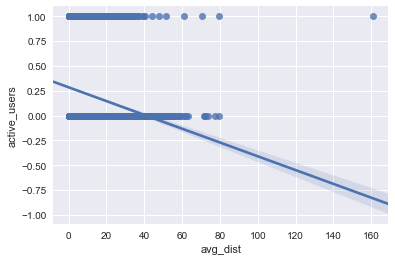

In [260]:
sns.regplot(y=df['active_users'], x=df['avg_dist'], fit_reg = True)
plt.show()

There seems to be a clear negative correlation between average distnace and whether a user is active or not. The higher a user's average distance per ride in the first 30 days of signup, the less likely that customer will become an active user after 6 months it appears.

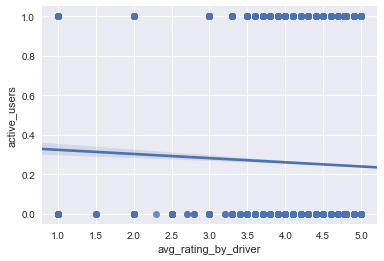

In [261]:
sns.regplot(y=df['active_users'], x=df['avg_rating_by_driver'], fit_reg = True)
plt.show()

There seems to be a very slight negative correlation between the average user rating and active users. What the plot is telling us is, the higher the average rating they receive from a driver, the less likely they are to be an active user after six months. This doesn't quite make sense. One would think that the higher the rating the customer receives, the MORE likely they would be to go on to become active users. Since there still appears some semblance of a correlation, we will include this feature in our model.

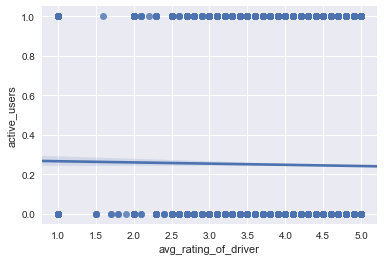

In [262]:
sns.regplot(y=df['active_users'], x=df['avg_rating_of_driver'], fit_reg = True)
plt.show()

There is no apparent correlation between the average rating given to a driver and active users. Therfore, we will not include this feature in our model.

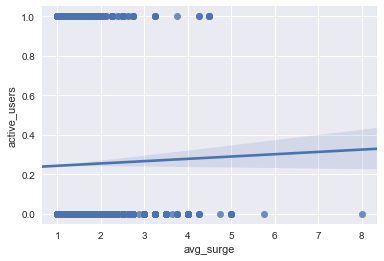

In [263]:
sns.regplot(y=df['active_users'], x=df['avg_surge'], fit_reg = True)
plt.show()

Again, there is almost no correlation between average surge and active users. We will forego this feature as well.

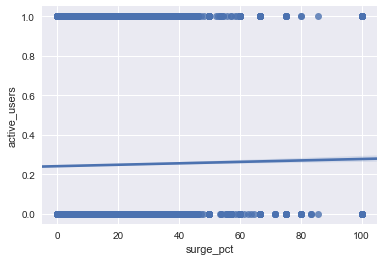

In [264]:
sns.regplot(y=df['active_users'], x=df['surge_pct'], fit_reg = True)
plt.show()

There is a very slight correlation between surge percentage and active users. We will go ahead and include this feature to see how it works within the model.

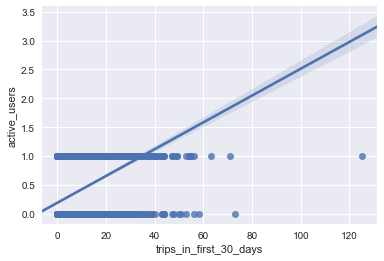

In [265]:
sns.regplot(y=df['active_users'], x=df['trips_in_first_30_days'], fit_reg = True)
plt.show()

Clearly, there is a very strong positive correlation between trips taken in the first 30 days and active users. For that reason, we will absolutely include this feature.

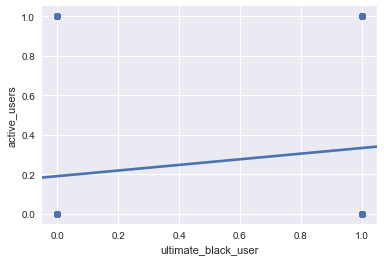

In [266]:
sns.regplot(y=df['active_users'], x=df['ultimate_black_user'], fit_reg = True)
plt.show()

There is a slight positive correlation between Ultimate Black users and active users. We will include this feature.

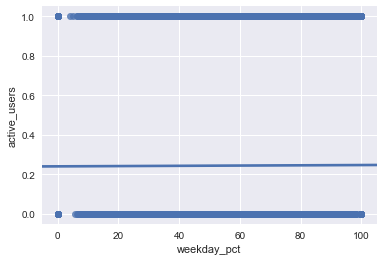

In [267]:
sns.regplot(y=df['active_users'], x=df['weekday_pct'], fit_reg = True)
plt.show()

No clear correlation here. We will not include weekday percentage in our model.

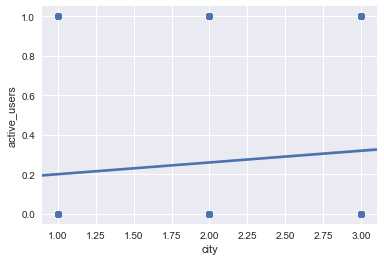

In [268]:
sns.regplot(y=df['active_users'], x=df['city'], fit_reg = True)
plt.show()

There is a slight correlation between city where the user signed up and active users. We will include this one.

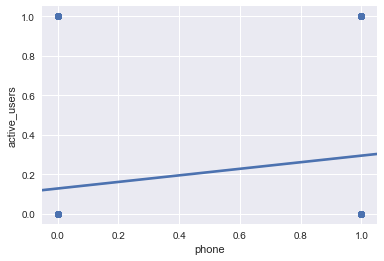

In [269]:
sns.regplot(y=df['active_users'], x=df['phone'], fit_reg = True)
plt.show()

There is a positive correlation between which phone a user has and whether they are an active user or not. We will include this feature in the model.

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

As mentioned earlier, I have decided to go with a logistic regression model for this projet. The ultimate goal is to predict whether a user WILL be active after 6 months of use or NOT. We only have two options here. Thereofre, logistic regression seems to be the clear choice.

In [290]:
#Create 'label' column
df['label'] = df.active_users == 1
df.label.replace(False, 0, inplace=True)
df.label.replace(True, 1, inplace=True)

In [418]:
#Designate the feature columns
feature_cols = ['avg_dist', 'avg_rating_by_driver', 'city', 'phone', 
                'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user']

#Create X and y variables
X = df[feature_cols]
y = df.label

In [419]:
#Import packages
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

#Split the training and testing data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [420]:
#Initiate the model
logreg = LogisticRegression()

#Fit the model with training data
logreg.fit(X_train,y_train)

#Predict using the testing data
y_pred=logreg.predict(X_test)

In [421]:
#Import metrics package to see confusion matrix
from sklearn import metrics

#Create confusion matrix and show results
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[9206,  206],
       [2640,  349]])

The confusion matrix above is telling us is that 9,206 and 349 are ACTUAL predictions, while 2,640 and 206 are INCORRECT predictions. To make this easier to digest, I will create a heatmap.

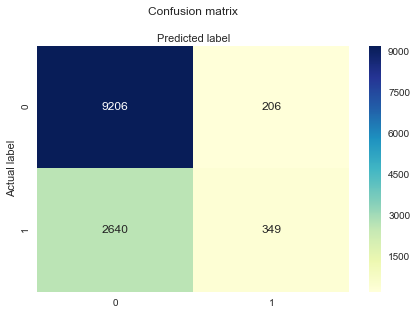

In [422]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [423]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7705023788404161
Precision: 0.6288288288288288
Recall: 0.1167614586818334


Our model's accuracy score is fairly good at 0.77. The precision score of .628 is also not too bad. This tells us that our model is not only ACCURATE, but PRECISE as well.

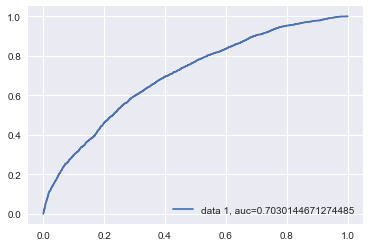

In [424]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The AUC score we received for the model is 0.703, which is decent. A score of 1 means that the model is a perfect classifier, while a score o 0.5 means the model is not very good at all. What we're seeing here is somewhere between both of those options.

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

What Ultimate could do to leverage the insights from this model is this: They could look at each feature that was used individually (avg_dist, avg_rating_by_driver, city, phone, surge_pct, trips_in_first_30_days, ultimate_black_user) and create a customer experience that will maximize them.

For example - We noticed that there was a very solid positive correlation between active users and trips in the first 30 days. What Ultimate could do is offer free or discounted rides to new users. This will help build brand loyalty and could improve customer retention down the road.

Another example - We know that there seems to be a slight positive correlation between iPhone users and active users. Ultimate could offer special promos to Apple users to help with retention.